# (02) AD: save data

**Motivation**: Saving extracted data and adjacency matrices allows fast loading and working with it later. <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def _apply():
    obj = ants.apply_transforms(
        fixed=affined,
        moving=reg.img_in_ccf(mask),
        transformlist=tx['invtransforms'],
        interpolator='genericLabel',
    )
    obj = tx_aff_inv.apply_to_image(
        image=obj,
        reference=reg.in_house,
        interpolation='multilabel',
    )
    obj = obj.numpy()
    for i_new, i in enumerate(np.unique(obj[obj.nonzero()])):
        obj[obj == i] = i_new + 1
    return obj

## Prepare

In [3]:
from register.register import Register

mice = Mice(Config(128, resolution=25), load_parcel=True)
mice.set_band(band_bo=(0.008,0.28))
reg = Register(mice)

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

## Registration subtasks

### Test if transform is correct

In [4]:
tx_fwd, tx_aff = reg.load_tx(reg.in_house_name, is_inv=False)
tx_inv, _ = reg.load_tx(reg.in_house_name, is_inv=True)
tx = {'fwdtransforms': tx_fwd, 'invtransforms': tx_inv}
tx_aff_inv = tx_aff.invert()

affined = tx_aff.apply_to_image(
    image=reg.in_house,
    reference=reg.template,
    interpolation='linear',
)
mask = mice.al.get_masks(['fiber tracts', 'VS', 'Isocortex'], as_objectmap=True)

In [5]:
reg.mi_base = ants.image_mutual_information(
    image1=reg.template, image2=reg.template)
scores, misc, warped = reg.tx_peformance(
    fixed=reg.template,
    moving=affined,
    moving_orig=reg.in_house,
    tx_aff=tx_aff,
    tx=tx,
)
obj = _apply()
scores

{
    'mi': 0.551089256337447,
    'ovp_MOp': 1.0,
    'sym_MOp': 1.0,
    'ovp_MOs': 1.0,
    'sym_MOs': 0.9939117199391172,
    'ovp_SS': 1.0,
    'sym_SS': 0.9986366734832992,
    'ovp_VISC': 1.0,
    'sym_VISC': 1.0,
    'ovp_VIS': 1.0,
    'sym_VIS': 0.9967897271268058,
    'ovp_AI': 1.0,
    'sym_AI': 0.9974747474747475,
    'ovp_PTLp': 1.0,
    'sym_PTLp': 0.9509803921568627,
    'ovp_TEa': 1.0,
    'sym_TEa': 0.9699248120300752,
    'ovp_CA1': 1.0,
    'sym_CA1': 0.9979633401221996,
    'ovp_CLA': 1.0,
    'sym_CLA': 1.0,
    'ovp_STRd': 1.0,
    'sym_STRd': 0.9975083056478405,
    'ovp_iso': 1.0,
    'sym_iso': 0.9962010015541357,
    'sym': 0.9960617110315744,
    'ovp': 1.0
}

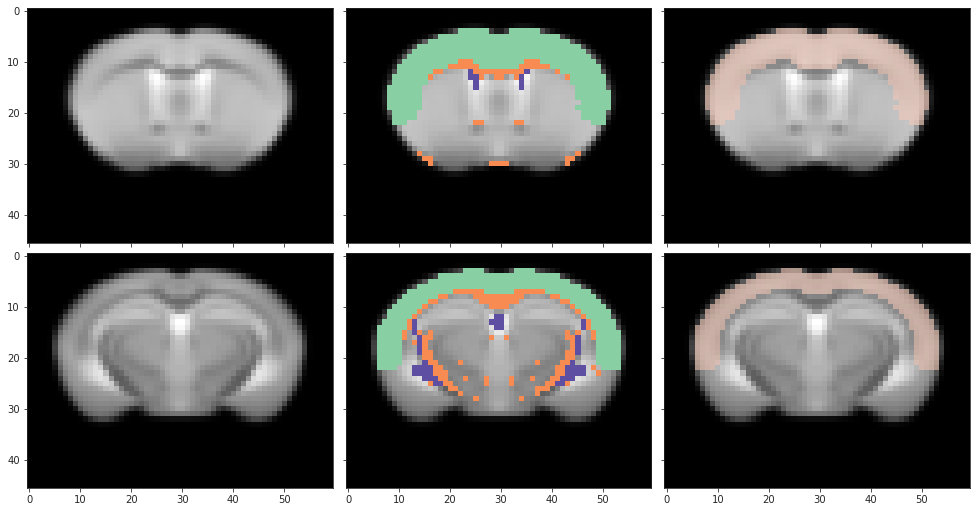

In [6]:
fig, axes = create_figure(2, 3, (13.5, 7), 'all', 'all', constrained_layout=True)
s_ = 29
for ax in axes[0].flat:
    ax.imshow(reg.in_house[s_], cmap='Greys_r')
axes[0, 1].imshow(mwh(obj[s_] == 0, obj[s_]), alpha=1, vmin=1.5, vmax=3.5, cmap='Spectral_r')
axes[0, 2].imshow(mwh(obj[s_] != 2, obj[s_]), alpha=0.5, vmin=0, vmax=10, cmap='Reds')

s_ = 41
for ax in axes[1].flat:
    ax.imshow(reg.in_house[s_], cmap='Greys_r')
axes[1, 1].imshow(mwh(obj[s_] == 0, obj[s_]), alpha=1, vmin=1.5, vmax=3.5, cmap='Spectral_r')
axes[1, 2].imshow(mwh(obj[s_] != 2, obj[s_]), alpha=0.5, vmin=0, vmax=10, cmap='Reds')
plt.show()

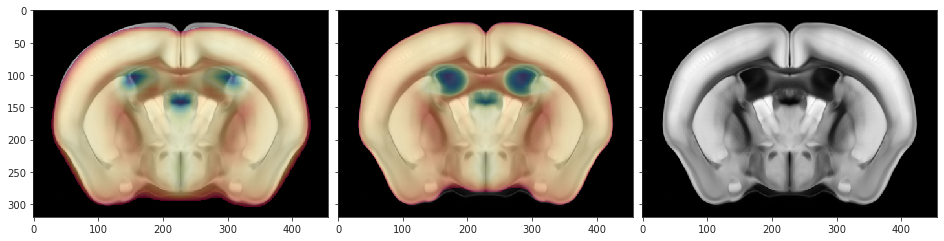

In [7]:
fig, axes = create_figure(1, 3, (13, 6), 'all', 'all', constrained_layout=True)
for i in range(3):
    axes[i].imshow(reg.template[240], cmap='Greys_r')
axes[0].imshow(mwh(affined[240] < 4000, affined[240]), alpha=0.5, cmap='Spectral')
axes[1].imshow(mwh(warped[240] < 4000, warped[240]), alpha=0.5, cmap='Spectral')
plt.show()

### Run equivalent of register_anat to save masks

In [ ]:
%%time

tx, tx_aff = reg.load_tx(reg.in_house_name)
affined = tx_aff.apply_to_image(
    image=reg.in_house,
    reference=reg.template,
    interpolation='linear',
)
_ = reg._apply_tx_obj2lps(
    tx=tx,
    tx_aff=tx_aff,
    moving=affined,
    name=reg.in_house_name,
    moving_orig=reg.in_house,
    save_results=True,
    extras=False,
    use_mm=True,
)

Takes about 20 mins

## Load full brain, erode

In [8]:
from register.parcellation import erode_parcellation

In [9]:
brain = 'Symmetric_N162_space-indiv3d_brain.nii.gz'
brain = ants.image_read(
    filename=pjoin(mice.cfg.masks_dir, brain),
    pixeltype='unsigned int',
).numpy()
brain.shape

(60, 46, 81)

In [10]:
eroded, r = erode_parcellation(brain, 'boundary')
eroded.shape, r

((60, 46, 81), 'boundary')

In [11]:
missing = sorted(set(unique_idxs(brain)) - set(unique_idxs(eroded)))
len(missing)

78

In [12]:
m = np.isin(brain, missing)
eroded[m] = brain[m]

In [13]:
missing = sorted(set(mice.parcel.df['id']) - set(unique_idxs(eroded)))
mice.parcel.df.loc[mice.parcel.df['id'].isin(missing)]

,id,acro,hemis,region,layer
257,258,Isocortex,1,2,2
361,362,Isocortex,1,106,2
641,642,Isocortex,2,2,2
745,746,Isocortex,2,106,2


### Plot results

In [14]:
in_house = reg.load_in_house().numpy()

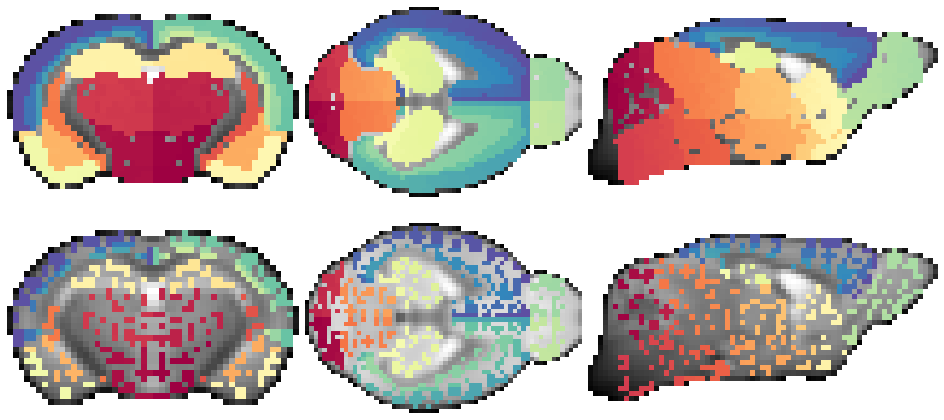

In [15]:
fig, axes = create_figure(2, 3, (13, 6), width_ratios=[1, 0.95, 1.2], constrained_layout=True)
for i, (axis, s_) in enumerate([(2, 40), (1, 10), (0, 24)]):
    data2p = filter_boundaries(
        x_list=[
            np.take(brain, s_, axis),
            np.take(eroded, s_, axis),
            np.take(in_house, s_, axis)],
        mask=np.take(in_house, s_, axis) > 2000,
    )
    if axis == 2:
        data2p = [e.T for e in data2p]
    for ax in axes[:, i].flat:
        ax.imshow(mwh(data2p[-1] < 2000, data2p[-1]), cmap='Greys_r')
    for j, x2p in enumerate(data2p[:-1]):
        axes[j, i].imshow(mwh(x2p == 0, x2p), alpha=1, cmap='Spectral_r')

remove_ticks(axes)
plt.show()

In [16]:
sizes_brain = unique_idxs(brain)
sizes_eroded = unique_idxs(eroded)
sizes_brain = {i: len(v) for i, v in sizes_brain.items()}
sizes_eroded = {i: len(v) for i, v in sizes_eroded.items()}

len(sizes_brain), len(sizes_eroded)

(2778, 2778)

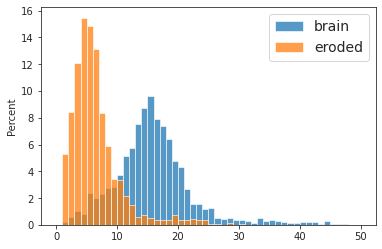

In [17]:
sns.histplot(list(sizes_brain.values()), color='C0', label='brain', stat='percent', bins=np.linspace(0, 50, 51))
sns.histplot(list(sizes_eroded.values()), color='C1', label='eroded', stat='percent', bins=np.linspace(0, 50, 51))
plt.legend(fontsize=14)
plt.show()

### Invert to match shapes

In [18]:
in_house = in_house[::-1][:, ::-1]
eroded = eroded[::-1][:, ::-1]

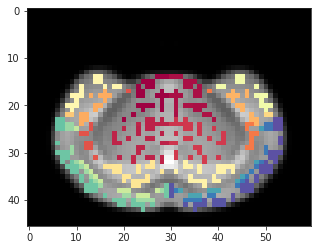

In [19]:
plt.imshow(in_house[..., 40].T, cmap='Greys_r')
plt.imshow(mwh(eroded[..., 40].T == 0, eroded[..., 40].T), cmap='Spectral_r');

## Get files, xtract, save

In [20]:
files = sorted(filter(
    lambda f: 'sub-DKI' in f or 'sub-WT'in f,
    os.listdir(mice.cfg.raw_dir),
))
len(files)

348

### Masks all

In [21]:
%%time

masks = []
for f in files:
    x = ants.image_read(pjoin(mice.cfg.raw_dir, f))
    masks.append(np.abs(x.numpy()).sum(-1) > 0)
mask_and = functools.reduce(np.logical_and, masks)
mask_or = functools.reduce(np.logical_or, masks)

_ = save_obj(
    obj=mask_and,
    file_name='AD_mask_and',
    save_dir=tmp_dir,
    mode='npy',
)
_ = save_obj(
    obj=mask_or,
    file_name='AD_mask_or',
    save_dir=tmp_dir,
    mode='npy',
)

[PROGRESS] 'AD_mask_and.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

[PROGRESS] 'AD_mask_or.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

CPU times: user 9min 27s, sys: 2min 34s, total: 12min 1s
Wall time: 12min 38s


In [22]:
len(unique_idxs(eroded[~mask_or]))

918

In [23]:
eroded[~mask_or] = 0

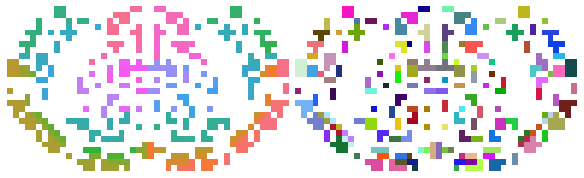

In [24]:
x2p = eroded[..., 40].T.copy()
x2p = filter_boundaries(x2p)
for i, r in enumerate(np.unique(x2p[x2p.nonzero()]), start=1):
    x2p[x2p == r] = i
x2p = mwh(x2p == 0, x2p)
fig, axes = create_figure(1, 2, (8, 3), constrained_layout=True)
axes[0].imshow(mwh(x2p == 0, x2p), cmap=sns.color_palette('husl', as_cmap=True))
axes[1].imshow(mwh(x2p == 0, x2p), cmap=get_rand_cmap(len(np.unique(x2p[x2p.nonzero()]))))
remove_ticks(axes)
plt.show()

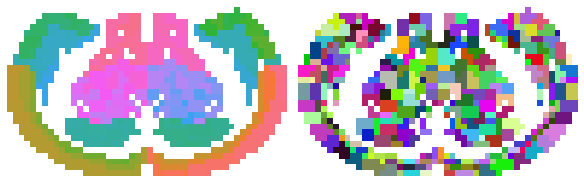

In [8]:
# Used to be brain

In [25]:
ids = np.unique(eroded[eroded.nonzero()])
n2i = {
    n: r for n, r
    in enumerate(ids)
}
_ = save_obj(
    obj=n2i,
    file_name='AD_n2i',
    save_dir=tmp_dir,
    mode='npy',
)
len(n2i)

[PROGRESS] 'AD_n2i.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

2365

### Data all

In [26]:
%%time

percent = {}
data_all = {}
for f in files:
    key = '_'.join(f.split('_')[:3])
    x = pjoin(mice.cfg.raw_dir, f)
    x = ants.image_read(x).numpy()
    data = np_nans((len(n2i), x.shape[-1]))
    for n, i in n2i.items():
        m = eroded == i
        if m.sum() == 0:
            print(mice.parcel(i))
            continue
        y = x[m].mean(0)
        if y.std() == 0:
            continue
        data[n] = y
    data_all[key] = data
    bad = np.isnan(data).sum(-1) == data.shape[-1]
    p = bad.sum() / len(data) * 100
    percent[key] = p

    msg = f"{key}:\t\ta total of {bad.sum()} / {len(data)} "
    msg += f"({p:0.1f} %) ROIs had zero STD"
    print(msg)

_ = save_obj(
    obj=data_all,
    file_name='AD_data',
    save_dir=tmp_dir,
    mode='npy',
)
len(data_all)

sub-DKI01_ses-1_run-1:          a total of 147 / 2365 (6.2 %) ROIs had zero STD

sub-DKI01_ses-1_run-2:          a total of 112 / 2365 (4.7 %) ROIs had zero STD

sub-DKI01_ses-1_run-3:          a total of 127 / 2365 (5.4 %) ROIs had zero STD

sub-DKI02_ses-1_run-1:          a total of 149 / 2365 (6.3 %) ROIs had zero STD

sub-DKI02_ses-1_run-2:          a total of 170 / 2365 (7.2 %) ROIs had zero STD

sub-DKI02_ses-1_run-3:          a total of 148 / 2365 (6.3 %) ROIs had zero STD

sub-DKI02_ses-2_run-1:          a total of 79 / 2365 (3.3 %) ROIs had zero STD

sub-DKI02_ses-2_run-2:          a total of 213 / 2365 (9.0 %) ROIs had zero STD

sub-DKI02_ses-2_run-3:          a total of 144 / 2365 (6.1 %) ROIs had zero STD

sub-DKI03_ses-1_run-1:          a total of 208 / 2365 (8.8 %) ROIs had zero STD

sub-DKI03_ses-1_run-2:          a total of 143 / 2365 (6.0 %) ROIs had zero STD

sub-DKI03_ses-1_run-3:          a total of 206 / 2365 (8.7 %) ROIs had zero STD

sub-DKI04_ses-1_run-1:          a total of 279 / 2365 (11.8 %) ROIs had zero STD

sub-DKI04_ses-1_run-2:          a total of 275 / 2365 (11.6 %) ROIs had zero STD

sub-DKI04_ses-1_run-3:          a total of 322 / 2365 (13.6 %) ROIs had zero STD

sub-DKI04_ses-2_run-1:          a total of 212 / 2365 (9.0 %) ROIs had zero STD

sub-DKI04_ses-2_run-2:          a total of 164 / 2365 (6.9 %) ROIs had zero STD

sub-DKI04_ses-2_run-3:          a total of 214 / 2365 (9.0 %) ROIs had zero STD

sub-DKI05_ses-1_run-1:          a total of 247 / 2365 (10.4 %) ROIs had zero STD

sub-DKI05_ses-1_run-2:          a total of 207 / 2365 (8.8 %) ROIs had zero STD

sub-DKI05_ses-1_run-3:          a total of 137 / 2365 (5.8 %) ROIs had zero STD

sub-DKI06_ses-1_run-1:          a total of 198 / 2365 (8.4 %) ROIs had zero STD

sub-DKI06_ses-1_run-2:          a total of 203 / 2365 (8.6 %) ROIs had zero STD

sub-DKI06_ses-1_run-3:          a total of 178 / 2365 (7.5 %) ROIs had zero STD

sub-DKI06_ses-2_run-1:          a total of 203 / 2365 (8.6 %) ROIs had zero STD

sub-DKI06_ses-2_run-2:          a total of 201 / 2365 (8.5 %) ROIs had zero STD

sub-DKI06_ses-2_run-3:          a total of 202 / 2365 (8.5 %) ROIs had zero STD

sub-DKI07_ses-1_run-1:          a total of 210 / 2365 (8.9 %) ROIs had zero STD

sub-DKI07_ses-1_run-2:          a total of 195 / 2365 (8.2 %) ROIs had zero STD

sub-DKI07_ses-1_run-3:          a total of 197 / 2365 (8.3 %) ROIs had zero STD

sub-DKI07_ses-2_run-1:          a total of 175 / 2365 (7.4 %) ROIs had zero STD

sub-DKI07_ses-2_run-2:          a total of 222 / 2365 (9.4 %) ROIs had zero STD

sub-DKI07_ses-2_run-3:          a total of 185 / 2365 (7.8 %) ROIs had zero STD

sub-DKI08_ses-1_run-1:          a total of 157 / 2365 (6.6 %) ROIs had zero STD

sub-DKI08_ses-1_run-2:          a total of 193 / 2365 (8.2 %) ROIs had zero STD

sub-DKI08_ses-1_run-3:          a total of 195 / 2365 (8.2 %) ROIs had zero STD

sub-DKI09_ses-1_run-1:          a total of 152 / 2365 (6.4 %) ROIs had zero STD

sub-DKI09_ses-1_run-2:          a total of 136 / 2365 (5.8 %) ROIs had zero STD

sub-DKI09_ses-1_run-3:          a total of 157 / 2365 (6.6 %) ROIs had zero STD

sub-DKI09_ses-2_run-1:          a total of 116 / 2365 (4.9 %) ROIs had zero STD

sub-DKI09_ses-2_run-2:          a total of 124 / 2365 (5.2 %) ROIs had zero STD

sub-DKI09_ses-2_run-3:          a total of 176 / 2365 (7.4 %) ROIs had zero STD

sub-DKI09_ses-3_run-1:          a total of 256 / 2365 (10.8 %) ROIs had zero STD

sub-DKI09_ses-3_run-2:          a total of 219 / 2365 (9.3 %) ROIs had zero STD

sub-DKI09_ses-3_run-3:          a total of 190 / 2365 (8.0 %) ROIs had zero STD

sub-DKI10_ses-1_run-1:          a total of 194 / 2365 (8.2 %) ROIs had zero STD

sub-DKI10_ses-1_run-2:          a total of 164 / 2365 (6.9 %) ROIs had zero STD

sub-DKI10_ses-1_run-3:          a total of 162 / 2365 (6.8 %) ROIs had zero STD

sub-DKI10_ses-2_run-1:          a total of 161 / 2365 (6.8 %) ROIs had zero STD

sub-DKI10_ses-2_run-2:          a total of 208 / 2365 (8.8 %) ROIs had zero STD

sub-DKI10_ses-2_run-3:          a total of 143 / 2365 (6.0 %) ROIs had zero STD

sub-DKI10_ses-3_run-1:          a total of 157 / 2365 (6.6 %) ROIs had zero STD

sub-DKI10_ses-3_run-2:          a total of 263 / 2365 (11.1 %) ROIs had zero STD

sub-DKI10_ses-3_run-3:          a total of 183 / 2365 (7.7 %) ROIs had zero STD

sub-DKI11_ses-1_run-1:          a total of 248 / 2365 (10.5 %) ROIs had zero STD

sub-DKI11_ses-1_run-2:          a total of 279 / 2365 (11.8 %) ROIs had zero STD

sub-DKI11_ses-1_run-3:          a total of 276 / 2365 (11.7 %) ROIs had zero STD

sub-DKI11_ses-2_run-1:          a total of 179 / 2365 (7.6 %) ROIs had zero STD

sub-DKI11_ses-2_run-2:          a total of 158 / 2365 (6.7 %) ROIs had zero STD

sub-DKI11_ses-2_run-3:          a total of 178 / 2365 (7.5 %) ROIs had zero STD

sub-DKI11_ses-3_run-1:          a total of 241 / 2365 (10.2 %) ROIs had zero STD

sub-DKI11_ses-3_run-2:          a total of 252 / 2365 (10.7 %) ROIs had zero STD

sub-DKI11_ses-3_run-3:          a total of 210 / 2365 (8.9 %) ROIs had zero STD

sub-DKI12_ses-1_run-1:          a total of 180 / 2365 (7.6 %) ROIs had zero STD

sub-DKI12_ses-1_run-2:          a total of 236 / 2365 (10.0 %) ROIs had zero STD

sub-DKI12_ses-1_run-3:          a total of 243 / 2365 (10.3 %) ROIs had zero STD

sub-DKI12_ses-2_run-1:          a total of 104 / 2365 (4.4 %) ROIs had zero STD

sub-DKI12_ses-2_run-2:          a total of 104 / 2365 (4.4 %) ROIs had zero STD

sub-DKI12_ses-2_run-3:          a total of 203 / 2365 (8.6 %) ROIs had zero STD

sub-DKI12_ses-3_run-1:          a total of 212 / 2365 (9.0 %) ROIs had zero STD

sub-DKI12_ses-3_run-2:          a total of 189 / 2365 (8.0 %) ROIs had zero STD

sub-DKI12_ses-3_run-3:          a total of 195 / 2365 (8.2 %) ROIs had zero STD

sub-DKI13_ses-1_run-1:          a total of 221 / 2365 (9.3 %) ROIs had zero STD

sub-DKI13_ses-1_run-2:          a total of 252 / 2365 (10.7 %) ROIs had zero STD

sub-DKI13_ses-1_run-3:          a total of 200 / 2365 (8.5 %) ROIs had zero STD

sub-DKI14_ses-1_run-1:          a total of 174 / 2365 (7.4 %) ROIs had zero STD

sub-DKI14_ses-1_run-2:          a total of 197 / 2365 (8.3 %) ROIs had zero STD

sub-DKI14_ses-1_run-3:          a total of 194 / 2365 (8.2 %) ROIs had zero STD

sub-DKI14_ses-3_run-1:          a total of 163 / 2365 (6.9 %) ROIs had zero STD

sub-DKI14_ses-3_run-2:          a total of 146 / 2365 (6.2 %) ROIs had zero STD

sub-DKI14_ses-3_run-3:          a total of 137 / 2365 (5.8 %) ROIs had zero STD

sub-DKI15_ses-1_run-1:          a total of 147 / 2365 (6.2 %) ROIs had zero STD

sub-DKI15_ses-1_run-2:          a total of 144 / 2365 (6.1 %) ROIs had zero STD

sub-DKI15_ses-1_run-3:          a total of 158 / 2365 (6.7 %) ROIs had zero STD

sub-DKI15_ses-3_run-1:          a total of 205 / 2365 (8.7 %) ROIs had zero STD

sub-DKI15_ses-3_run-2:          a total of 248 / 2365 (10.5 %) ROIs had zero STD

sub-DKI15_ses-3_run-3:          a total of 165 / 2365 (7.0 %) ROIs had zero STD

sub-DKI16_ses-3_run-1:          a total of 269 / 2365 (11.4 %) ROIs had zero STD

sub-DKI16_ses-3_run-2:          a total of 298 / 2365 (12.6 %) ROIs had zero STD

sub-DKI17_ses-3_run-1:          a total of 267 / 2365 (11.3 %) ROIs had zero STD

sub-DKI17_ses-3_run-2:          a total of 324 / 2365 (13.7 %) ROIs had zero STD

sub-DKI17_ses-3_run-3:          a total of 217 / 2365 (9.2 %) ROIs had zero STD

sub-DKI18_ses-3_run-1:          a total of 188 / 2365 (7.9 %) ROIs had zero STD

sub-DKI18_ses-3_run-2:          a total of 223 / 2365 (9.4 %) ROIs had zero STD

sub-DKI18_ses-3_run-3:          a total of 282 / 2365 (11.9 %) ROIs had zero STD

sub-DKI19_ses-3_run-1:          a total of 321 / 2365 (13.6 %) ROIs had zero STD

sub-DKI19_ses-3_run-2:          a total of 282 / 2365 (11.9 %) ROIs had zero STD

sub-DKI19_ses-3_run-3:          a total of 310 / 2365 (13.1 %) ROIs had zero STD

sub-DKI20_ses-3_run-1:          a total of 179 / 2365 (7.6 %) ROIs had zero STD

sub-DKI20_ses-3_run-2:          a total of 289 / 2365 (12.2 %) ROIs had zero STD

sub-DKI20_ses-3_run-3:          a total of 227 / 2365 (9.6 %) ROIs had zero STD

sub-DKI21_ses-2_run-1:          a total of 247 / 2365 (10.4 %) ROIs had zero STD

sub-DKI21_ses-2_run-2:          a total of 257 / 2365 (10.9 %) ROIs had zero STD

sub-DKI21_ses-2_run-3:          a total of 287 / 2365 (12.1 %) ROIs had zero STD

sub-DKI22_ses-5_run-1:          a total of 196 / 2365 (8.3 %) ROIs had zero STD

sub-DKI22_ses-5_run-2:          a total of 186 / 2365 (7.9 %) ROIs had zero STD

sub-DKI22_ses-5_run-3:          a total of 184 / 2365 (7.8 %) ROIs had zero STD

sub-DKI22_ses-6_run-1:          a total of 199 / 2365 (8.4 %) ROIs had zero STD

sub-DKI22_ses-6_run-2:          a total of 135 / 2365 (5.7 %) ROIs had zero STD

sub-DKI22_ses-6_run-3:          a total of 166 / 2365 (7.0 %) ROIs had zero STD

sub-DKI23_ses-5_run-1:          a total of 229 / 2365 (9.7 %) ROIs had zero STD

sub-DKI23_ses-5_run-2:          a total of 213 / 2365 (9.0 %) ROIs had zero STD

sub-DKI23_ses-5_run-3:          a total of 246 / 2365 (10.4 %) ROIs had zero STD

sub-DKI23_ses-6_run-1:          a total of 210 / 2365 (8.9 %) ROIs had zero STD

sub-DKI23_ses-6_run-2:          a total of 208 / 2365 (8.8 %) ROIs had zero STD

sub-DKI23_ses-6_run-3:          a total of 212 / 2365 (9.0 %) ROIs had zero STD

sub-DKI24_ses-5_run-1:          a total of 195 / 2365 (8.2 %) ROIs had zero STD

sub-DKI24_ses-5_run-2:          a total of 219 / 2365 (9.3 %) ROIs had zero STD

sub-DKI24_ses-5_run-3:          a total of 218 / 2365 (9.2 %) ROIs had zero STD

sub-DKI24_ses-6_run-1:          a total of 229 / 2365 (9.7 %) ROIs had zero STD

sub-DKI24_ses-6_run-2:          a total of 193 / 2365 (8.2 %) ROIs had zero STD

sub-DKI24_ses-6_run-3:          a total of 188 / 2365 (7.9 %) ROIs had zero STD

sub-DKI25_ses-5_run-1:          a total of 191 / 2365 (8.1 %) ROIs had zero STD

sub-DKI25_ses-5_run-2:          a total of 204 / 2365 (8.6 %) ROIs had zero STD

sub-DKI25_ses-5_run-3:          a total of 242 / 2365 (10.2 %) ROIs had zero STD

sub-DKI25_ses-6_run-1:          a total of 249 / 2365 (10.5 %) ROIs had zero STD

sub-DKI25_ses-6_run-2:          a total of 246 / 2365 (10.4 %) ROIs had zero STD

sub-DKI25_ses-6_run-3:          a total of 283 / 2365 (12.0 %) ROIs had zero STD

sub-DKI26_ses-5_run-1:          a total of 195 / 2365 (8.2 %) ROIs had zero STD

sub-DKI26_ses-5_run-2:          a total of 242 / 2365 (10.2 %) ROIs had zero STD

sub-DKI26_ses-6_run-1:          a total of 217 / 2365 (9.2 %) ROIs had zero STD

sub-DKI26_ses-6_run-2:          a total of 177 / 2365 (7.5 %) ROIs had zero STD

sub-DKI26_ses-6_run-3:          a total of 183 / 2365 (7.7 %) ROIs had zero STD

sub-DKI27_ses-5_run-1:          a total of 250 / 2365 (10.6 %) ROIs had zero STD

sub-DKI27_ses-5_run-2:          a total of 181 / 2365 (7.7 %) ROIs had zero STD

sub-DKI27_ses-5_run-3:          a total of 184 / 2365 (7.8 %) ROIs had zero STD

sub-DKI27_ses-6_run-1:          a total of 174 / 2365 (7.4 %) ROIs had zero STD

sub-DKI27_ses-6_run-2:          a total of 152 / 2365 (6.4 %) ROIs had zero STD

sub-DKI27_ses-6_run-3:          a total of 143 / 2365 (6.0 %) ROIs had zero STD

sub-DKI28_ses-5_run-1:          a total of 201 / 2365 (8.5 %) ROIs had zero STD

sub-DKI28_ses-5_run-2:          a total of 203 / 2365 (8.6 %) ROIs had zero STD

sub-DKI28_ses-5_run-3:          a total of 196 / 2365 (8.3 %) ROIs had zero STD

sub-DKI28_ses-6_run-1:          a total of 229 / 2365 (9.7 %) ROIs had zero STD

sub-DKI28_ses-6_run-2:          a total of 275 / 2365 (11.6 %) ROIs had zero STD

sub-DKI28_ses-6_run-3:          a total of 250 / 2365 (10.6 %) ROIs had zero STD

sub-DKI29_ses-5_run-1:          a total of 201 / 2365 (8.5 %) ROIs had zero STD

sub-DKI29_ses-5_run-2:          a total of 179 / 2365 (7.6 %) ROIs had zero STD

sub-DKI29_ses-5_run-3:          a total of 184 / 2365 (7.8 %) ROIs had zero STD

sub-DKI29_ses-6_run-1:          a total of 203 / 2365 (8.6 %) ROIs had zero STD

sub-DKI29_ses-6_run-2:          a total of 182 / 2365 (7.7 %) ROIs had zero STD

sub-DKI30_ses-5_run-1:          a total of 201 / 2365 (8.5 %) ROIs had zero STD

sub-DKI30_ses-5_run-2:          a total of 230 / 2365 (9.7 %) ROIs had zero STD

sub-DKI30_ses-5_run-3:          a total of 164 / 2365 (6.9 %) ROIs had zero STD

sub-DKI30_ses-6_run-1:          a total of 225 / 2365 (9.5 %) ROIs had zero STD

sub-DKI30_ses-6_run-2:          a total of 220 / 2365 (9.3 %) ROIs had zero STD

sub-DKI30_ses-6_run-3:          a total of 245 / 2365 (10.4 %) ROIs had zero STD

sub-DKI31_ses-5_run-1:          a total of 241 / 2365 (10.2 %) ROIs had zero STD

sub-DKI31_ses-5_run-2:          a total of 244 / 2365 (10.3 %) ROIs had zero STD

sub-DKI31_ses-5_run-3:          a total of 253 / 2365 (10.7 %) ROIs had zero STD

sub-DKI31_ses-6_run-1:          a total of 151 / 2365 (6.4 %) ROIs had zero STD

sub-DKI31_ses-6_run-2:          a total of 232 / 2365 (9.8 %) ROIs had zero STD

sub-DKI31_ses-6_run-3:          a total of 207 / 2365 (8.8 %) ROIs had zero STD

sub-DKI32_ses-5_run-1:          a total of 274 / 2365 (11.6 %) ROIs had zero STD

sub-DKI32_ses-5_run-2:          a total of 278 / 2365 (11.8 %) ROIs had zero STD

sub-DKI32_ses-5_run-3:          a total of 251 / 2365 (10.6 %) ROIs had zero STD

sub-DKI32_ses-6_run-1:          a total of 239 / 2365 (10.1 %) ROIs had zero STD

sub-DKI32_ses-6_run-2:          a total of 218 / 2365 (9.2 %) ROIs had zero STD

sub-DKI32_ses-6_run-3:          a total of 232 / 2365 (9.8 %) ROIs had zero STD

sub-DKI33_ses-5_run-1:          a total of 284 / 2365 (12.0 %) ROIs had zero STD

sub-DKI33_ses-5_run-2:          a total of 323 / 2365 (13.7 %) ROIs had zero STD

sub-DKI33_ses-5_run-3:          a total of 293 / 2365 (12.4 %) ROIs had zero STD

sub-DKI33_ses-6_run-1:          a total of 288 / 2365 (12.2 %) ROIs had zero STD

sub-DKI33_ses-6_run-2:          a total of 285 / 2365 (12.1 %) ROIs had zero STD

sub-DKI33_ses-6_run-3:          a total of 189 / 2365 (8.0 %) ROIs had zero STD

sub-DKI34_ses-5_run-1:          a total of 259 / 2365 (11.0 %) ROIs had zero STD

sub-DKI34_ses-5_run-2:          a total of 286 / 2365 (12.1 %) ROIs had zero STD

sub-DKI34_ses-5_run-3:          a total of 235 / 2365 (9.9 %) ROIs had zero STD

sub-DKI34_ses-6_run-1:          a total of 176 / 2365 (7.4 %) ROIs had zero STD

sub-DKI34_ses-6_run-2:          a total of 161 / 2365 (6.8 %) ROIs had zero STD

sub-DKI34_ses-6_run-3:          a total of 126 / 2365 (5.3 %) ROIs had zero STD

sub-DKI35_ses-5_run-1:          a total of 163 / 2365 (6.9 %) ROIs had zero STD

sub-DKI35_ses-5_run-2:          a total of 177 / 2365 (7.5 %) ROIs had zero STD

sub-DKI35_ses-5_run-3:          a total of 156 / 2365 (6.6 %) ROIs had zero STD

sub-DKI36_ses-5_run-1:          a total of 271 / 2365 (11.5 %) ROIs had zero STD

sub-DKI36_ses-5_run-2:          a total of 292 / 2365 (12.3 %) ROIs had zero STD

sub-DKI36_ses-5_run-3:          a total of 272 / 2365 (11.5 %) ROIs had zero STD

sub-DKI36_ses-6_run-1:          a total of 189 / 2365 (8.0 %) ROIs had zero STD

sub-DKI36_ses-6_run-2:          a total of 193 / 2365 (8.2 %) ROIs had zero STD

sub-DKI36_ses-6_run-3:          a total of 203 / 2365 (8.6 %) ROIs had zero STD

sub-DKI37_ses-5_run-1:          a total of 281 / 2365 (11.9 %) ROIs had zero STD

sub-DKI37_ses-5_run-2:          a total of 293 / 2365 (12.4 %) ROIs had zero STD

sub-DKI37_ses-6_run-1:          a total of 175 / 2365 (7.4 %) ROIs had zero STD

sub-DKI37_ses-6_run-2:          a total of 202 / 2365 (8.5 %) ROIs had zero STD

sub-DKI38_ses-5_run-1:          a total of 271 / 2365 (11.5 %) ROIs had zero STD

sub-DKI38_ses-5_run-2:          a total of 295 / 2365 (12.5 %) ROIs had zero STD

sub-DKI38_ses-5_run-3:          a total of 269 / 2365 (11.4 %) ROIs had zero STD

sub-DKI39_ses-5_run-1:          a total of 344 / 2365 (14.5 %) ROIs had zero STD

sub-DKI39_ses-5_run-2:          a total of 296 / 2365 (12.5 %) ROIs had zero STD

sub-DKI39_ses-5_run-3:          a total of 385 / 2365 (16.3 %) ROIs had zero STD

sub-DKI39_ses-6_run-1:          a total of 190 / 2365 (8.0 %) ROIs had zero STD

sub-DKI39_ses-6_run-2:          a total of 183 / 2365 (7.7 %) ROIs had zero STD

sub-DKI39_ses-6_run-3:          a total of 275 / 2365 (11.6 %) ROIs had zero STD

sub-DKI40_ses-5_run-1:          a total of 277 / 2365 (11.7 %) ROIs had zero STD

sub-DKI40_ses-5_run-2:          a total of 294 / 2365 (12.4 %) ROIs had zero STD

sub-DKI40_ses-5_run-3:          a total of 285 / 2365 (12.1 %) ROIs had zero STD

sub-DKI40_ses-6_run-1:          a total of 350 / 2365 (14.8 %) ROIs had zero STD

sub-DKI40_ses-6_run-2:          a total of 299 / 2365 (12.6 %) ROIs had zero STD

sub-DKI40_ses-6_run-3:          a total of 288 / 2365 (12.2 %) ROIs had zero STD

sub-DKI41_ses-5_run-1:          a total of 273 / 2365 (11.5 %) ROIs had zero STD

sub-DKI41_ses-5_run-2:          a total of 182 / 2365 (7.7 %) ROIs had zero STD

sub-DKI41_ses-5_run-3:          a total of 204 / 2365 (8.6 %) ROIs had zero STD

sub-DKI41_ses-6_run-1:          a total of 201 / 2365 (8.5 %) ROIs had zero STD

sub-DKI41_ses-6_run-2:          a total of 157 / 2365 (6.6 %) ROIs had zero STD

sub-DKI41_ses-6_run-3:          a total of 159 / 2365 (6.7 %) ROIs had zero STD

sub-DKI42_ses-2_run-1:          a total of 275 / 2365 (11.6 %) ROIs had zero STD

sub-DKI42_ses-2_run-2:          a total of 250 / 2365 (10.6 %) ROIs had zero STD

sub-DKI42_ses-2_run-3:          a total of 288 / 2365 (12.2 %) ROIs had zero STD

sub-DKI43_ses-2_run-1:          a total of 278 / 2365 (11.8 %) ROIs had zero STD

sub-DKI43_ses-2_run-2:          a total of 229 / 2365 (9.7 %) ROIs had zero STD

sub-DKI43_ses-2_run-3:          a total of 226 / 2365 (9.6 %) ROIs had zero STD

sub-DKI44_ses-2_run-1:          a total of 307 / 2365 (13.0 %) ROIs had zero STD

sub-DKI44_ses-2_run-2:          a total of 296 / 2365 (12.5 %) ROIs had zero STD

sub-DKI44_ses-2_run-3:          a total of 289 / 2365 (12.2 %) ROIs had zero STD

sub-WT01_ses-1_run-1:           a total of 160 / 2365 (6.8 %) ROIs had zero STD

sub-WT01_ses-1_run-2:           a total of 187 / 2365 (7.9 %) ROIs had zero STD

sub-WT01_ses-1_run-3:           a total of 170 / 2365 (7.2 %) ROIs had zero STD

sub-WT01_ses-2_run-1:           a total of 297 / 2365 (12.6 %) ROIs had zero STD

sub-WT01_ses-2_run-2:           a total of 337 / 2365 (14.2 %) ROIs had zero STD

sub-WT01_ses-2_run-3:           a total of 324 / 2365 (13.7 %) ROIs had zero STD

sub-WT01_ses-3_run-1:           a total of 115 / 2365 (4.9 %) ROIs had zero STD

sub-WT01_ses-3_run-2:           a total of 118 / 2365 (5.0 %) ROIs had zero STD

sub-WT01_ses-3_run-3:           a total of 138 / 2365 (5.8 %) ROIs had zero STD

sub-WT02_ses-1_run-1:           a total of 206 / 2365 (8.7 %) ROIs had zero STD

sub-WT02_ses-1_run-2:           a total of 159 / 2365 (6.7 %) ROIs had zero STD

sub-WT02_ses-1_run-3:           a total of 121 / 2365 (5.1 %) ROIs had zero STD

sub-WT02_ses-2_run-1:           a total of 218 / 2365 (9.2 %) ROIs had zero STD

sub-WT02_ses-2_run-2:           a total of 244 / 2365 (10.3 %) ROIs had zero STD

sub-WT02_ses-2_run-3:           a total of 236 / 2365 (10.0 %) ROIs had zero STD

sub-WT02_ses-3_run-1:           a total of 217 / 2365 (9.2 %) ROIs had zero STD

sub-WT02_ses-3_run-2:           a total of 208 / 2365 (8.8 %) ROIs had zero STD

sub-WT02_ses-3_run-3:           a total of 193 / 2365 (8.2 %) ROIs had zero STD

sub-WT03_ses-1_run-1:           a total of 258 / 2365 (10.9 %) ROIs had zero STD

sub-WT03_ses-1_run-2:           a total of 238 / 2365 (10.1 %) ROIs had zero STD

sub-WT03_ses-1_run-3:           a total of 258 / 2365 (10.9 %) ROIs had zero STD

sub-WT03_ses-2_run-1:           a total of 243 / 2365 (10.3 %) ROIs had zero STD

sub-WT03_ses-2_run-2:           a total of 224 / 2365 (9.5 %) ROIs had zero STD

sub-WT03_ses-2_run-3:           a total of 217 / 2365 (9.2 %) ROIs had zero STD

sub-WT04_ses-1_run-1:           a total of 163 / 2365 (6.9 %) ROIs had zero STD

sub-WT04_ses-1_run-2:           a total of 165 / 2365 (7.0 %) ROIs had zero STD

sub-WT04_ses-1_run-3:           a total of 162 / 2365 (6.8 %) ROIs had zero STD

sub-WT04_ses-2_run-1:           a total of 213 / 2365 (9.0 %) ROIs had zero STD

sub-WT04_ses-2_run-2:           a total of 213 / 2365 (9.0 %) ROIs had zero STD

sub-WT04_ses-2_run-3:           a total of 187 / 2365 (7.9 %) ROIs had zero STD

sub-WT05_ses-1_run-1:           a total of 191 / 2365 (8.1 %) ROIs had zero STD

sub-WT05_ses-1_run-2:           a total of 169 / 2365 (7.1 %) ROIs had zero STD

sub-WT05_ses-1_run-3:           a total of 206 / 2365 (8.7 %) ROIs had zero STD

sub-WT05_ses-2_run-1:           a total of 249 / 2365 (10.5 %) ROIs had zero STD

sub-WT05_ses-2_run-2:           a total of 156 / 2365 (6.6 %) ROIs had zero STD

sub-WT05_ses-2_run-3:           a total of 211 / 2365 (8.9 %) ROIs had zero STD

sub-WT06_ses-1_run-1:           a total of 261 / 2365 (11.0 %) ROIs had zero STD

sub-WT06_ses-1_run-2:           a total of 230 / 2365 (9.7 %) ROIs had zero STD

sub-WT06_ses-1_run-3:           a total of 247 / 2365 (10.4 %) ROIs had zero STD

sub-WT06_ses-2_run-1:           a total of 166 / 2365 (7.0 %) ROIs had zero STD

sub-WT06_ses-2_run-2:           a total of 151 / 2365 (6.4 %) ROIs had zero STD

sub-WT06_ses-2_run-3:           a total of 125 / 2365 (5.3 %) ROIs had zero STD

sub-WT07_ses-1_run-1:           a total of 191 / 2365 (8.1 %) ROIs had zero STD

sub-WT07_ses-1_run-2:           a total of 273 / 2365 (11.5 %) ROIs had zero STD

sub-WT07_ses-1_run-3:           a total of 181 / 2365 (7.7 %) ROIs had zero STD

sub-WT07_ses-1_run-4:           a total of 279 / 2365 (11.8 %) ROIs had zero STD

sub-WT07_ses-2_run-1:           a total of 125 / 2365 (5.3 %) ROIs had zero STD

sub-WT07_ses-2_run-2:           a total of 118 / 2365 (5.0 %) ROIs had zero STD

sub-WT07_ses-2_run-3:           a total of 91 / 2365 (3.8 %) ROIs had zero STD

sub-WT08_ses-1_run-1:           a total of 211 / 2365 (8.9 %) ROIs had zero STD

sub-WT08_ses-1_run-2:           a total of 218 / 2365 (9.2 %) ROIs had zero STD

sub-WT08_ses-2_run-1:           a total of 165 / 2365 (7.0 %) ROIs had zero STD

sub-WT08_ses-2_run-2:           a total of 176 / 2365 (7.4 %) ROIs had zero STD

sub-WT08_ses-2_run-3:           a total of 161 / 2365 (6.8 %) ROIs had zero STD

sub-WT09_ses-1_run-1:           a total of 246 / 2365 (10.4 %) ROIs had zero STD

sub-WT09_ses-1_run-2:           a total of 186 / 2365 (7.9 %) ROIs had zero STD

sub-WT09_ses-1_run-3:           a total of 189 / 2365 (8.0 %) ROIs had zero STD

sub-WT09_ses-2_run-1:           a total of 128 / 2365 (5.4 %) ROIs had zero STD

sub-WT09_ses-2_run-2:           a total of 179 / 2365 (7.6 %) ROIs had zero STD

sub-WT09_ses-2_run-3:           a total of 127 / 2365 (5.4 %) ROIs had zero STD

sub-WT10_ses-1_run-1:           a total of 171 / 2365 (7.2 %) ROIs had zero STD

sub-WT10_ses-1_run-2:           a total of 182 / 2365 (7.7 %) ROIs had zero STD

sub-WT10_ses-1_run-3:           a total of 174 / 2365 (7.4 %) ROIs had zero STD

sub-WT10_ses-2_run-1:           a total of 132 / 2365 (5.6 %) ROIs had zero STD

sub-WT10_ses-2_run-2:           a total of 131 / 2365 (5.5 %) ROIs had zero STD

sub-WT10_ses-2_run-3:           a total of 167 / 2365 (7.1 %) ROIs had zero STD

sub-WT11_ses-3_run-1:           a total of 300 / 2365 (12.7 %) ROIs had zero STD

sub-WT11_ses-3_run-2:           a total of 324 / 2365 (13.7 %) ROIs had zero STD

sub-WT11_ses-3_run-3:           a total of 310 / 2365 (13.1 %) ROIs had zero STD

sub-WT12_ses-3_run-1:           a total of 201 / 2365 (8.5 %) ROIs had zero STD

sub-WT12_ses-3_run-2:           a total of 217 / 2365 (9.2 %) ROIs had zero STD

sub-WT12_ses-3_run-3:           a total of 151 / 2365 (6.4 %) ROIs had zero STD

sub-WT13_ses-3_run-1:           a total of 299 / 2365 (12.6 %) ROIs had zero STD

sub-WT13_ses-3_run-2:           a total of 310 / 2365 (13.1 %) ROIs had zero STD

sub-WT13_ses-3_run-3:           a total of 278 / 2365 (11.8 %) ROIs had zero STD

sub-WT14_ses-3_run-1:           a total of 180 / 2365 (7.6 %) ROIs had zero STD

sub-WT14_ses-3_run-2:           a total of 174 / 2365 (7.4 %) ROIs had zero STD

sub-WT14_ses-3_run-3:           a total of 169 / 2365 (7.1 %) ROIs had zero STD

sub-WT15_ses-3_run-1:           a total of 339 / 2365 (14.3 %) ROIs had zero STD

sub-WT15_ses-3_run-2:           a total of 415 / 2365 (17.5 %) ROIs had zero STD

sub-WT16_ses-3_run-1:           a total of 241 / 2365 (10.2 %) ROIs had zero STD

sub-WT16_ses-3_run-2:           a total of 153 / 2365 (6.5 %) ROIs had zero STD

sub-WT16_ses-3_run-3:           a total of 250 / 2365 (10.6 %) ROIs had zero STD

sub-WT17_ses-3_run-1:           a total of 262 / 2365 (11.1 %) ROIs had zero STD

sub-WT17_ses-3_run-2:           a total of 233 / 2365 (9.9 %) ROIs had zero STD

sub-WT17_ses-3_run-3:           a total of 196 / 2365 (8.3 %) ROIs had zero STD

sub-WT18_ses-5_run-1:           a total of 253 / 2365 (10.7 %) ROIs had zero STD

sub-WT18_ses-5_run-2:           a total of 266 / 2365 (11.2 %) ROIs had zero STD

sub-WT18_ses-5_run-3:           a total of 211 / 2365 (8.9 %) ROIs had zero STD

sub-WT18_ses-6_run-1:           a total of 173 / 2365 (7.3 %) ROIs had zero STD

sub-WT18_ses-6_run-2:           a total of 178 / 2365 (7.5 %) ROIs had zero STD

sub-WT18_ses-6_run-3:           a total of 181 / 2365 (7.7 %) ROIs had zero STD

sub-WT19_ses-5_run-1:           a total of 284 / 2365 (12.0 %) ROIs had zero STD

sub-WT19_ses-5_run-2:           a total of 263 / 2365 (11.1 %) ROIs had zero STD

sub-WT19_ses-5_run-3:           a total of 279 / 2365 (11.8 %) ROIs had zero STD

sub-WT19_ses-6_run-1:           a total of 326 / 2365 (13.8 %) ROIs had zero STD

sub-WT19_ses-6_run-2:           a total of 319 / 2365 (13.5 %) ROIs had zero STD

sub-WT19_ses-6_run-3:           a total of 291 / 2365 (12.3 %) ROIs had zero STD

sub-WT20_ses-5_run-1:           a total of 217 / 2365 (9.2 %) ROIs had zero STD

sub-WT20_ses-5_run-2:           a total of 311 / 2365 (13.2 %) ROIs had zero STD

sub-WT20_ses-5_run-3:           a total of 268 / 2365 (11.3 %) ROIs had zero STD

sub-WT20_ses-6_run-1:           a total of 217 / 2365 (9.2 %) ROIs had zero STD

sub-WT20_ses-6_run-2:           a total of 229 / 2365 (9.7 %) ROIs had zero STD

sub-WT20_ses-6_run-3:           a total of 176 / 2365 (7.4 %) ROIs had zero STD

sub-WT21_ses-5_run-1:           a total of 259 / 2365 (11.0 %) ROIs had zero STD

sub-WT21_ses-5_run-2:           a total of 266 / 2365 (11.2 %) ROIs had zero STD

sub-WT21_ses-5_run-3:           a total of 249 / 2365 (10.5 %) ROIs had zero STD

sub-WT21_ses-6_run-1:           a total of 199 / 2365 (8.4 %) ROIs had zero STD

sub-WT21_ses-6_run-2:           a total of 183 / 2365 (7.7 %) ROIs had zero STD

sub-WT21_ses-6_run-3:           a total of 167 / 2365 (7.1 %) ROIs had zero STD

sub-WT22_ses-5_run-1:           a total of 181 / 2365 (7.7 %) ROIs had zero STD

sub-WT22_ses-5_run-2:           a total of 200 / 2365 (8.5 %) ROIs had zero STD

sub-WT22_ses-5_run-3:           a total of 202 / 2365 (8.5 %) ROIs had zero STD

sub-WT22_ses-6_run-1:           a total of 149 / 2365 (6.3 %) ROIs had zero STD

sub-WT22_ses-6_run-2:           a total of 181 / 2365 (7.7 %) ROIs had zero STD

sub-WT22_ses-6_run-3:           a total of 160 / 2365 (6.8 %) ROIs had zero STD

sub-WT23_ses-5_run-1:           a total of 293 / 2365 (12.4 %) ROIs had zero STD

sub-WT23_ses-5_run-2:           a total of 264 / 2365 (11.2 %) ROIs had zero STD

sub-WT23_ses-5_run-3:           a total of 196 / 2365 (8.3 %) ROIs had zero STD

sub-WT24_ses-5_run-1:           a total of 179 / 2365 (7.6 %) ROIs had zero STD

sub-WT24_ses-5_run-2:           a total of 182 / 2365 (7.7 %) ROIs had zero STD

sub-WT24_ses-5_run-3:           a total of 203 / 2365 (8.6 %) ROIs had zero STD

sub-WT25_ses-5_run-1:           a total of 228 / 2365 (9.6 %) ROIs had zero STD

sub-WT25_ses-5_run-2:           a total of 221 / 2365 (9.3 %) ROIs had zero STD

sub-WT25_ses-5_run-3:           a total of 257 / 2365 (10.9 %) ROIs had zero STD

[PROGRESS] 'AD_data.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

CPU times: user 20min 28s, sys: 2min 18s, total: 22min 46s
Wall time: 22min 42s


348

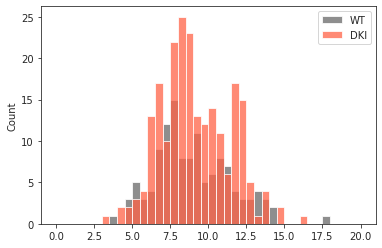

In [27]:
sns.histplot(
    [v for k, v in percent.items() if 'WT' in k],
    color='dimgrey', label='WT', bins=np.linspace(0, 20, 41)
)
sns.histplot(
    [v for k, v in percent.items() if 'DKI' in k],
    color='tomato', label='DKI', bins=np.linspace(0, 20, 41)
)
plt.legend()
plt.show()

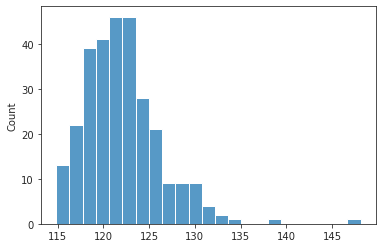

In [28]:
sns.histplot(np.nanstd(data, 0));

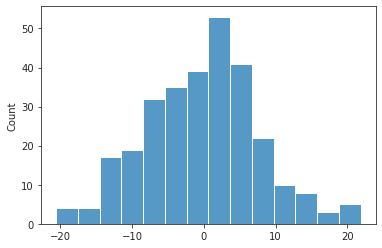

In [29]:
sns.histplot(np.nanmean(data, 0));

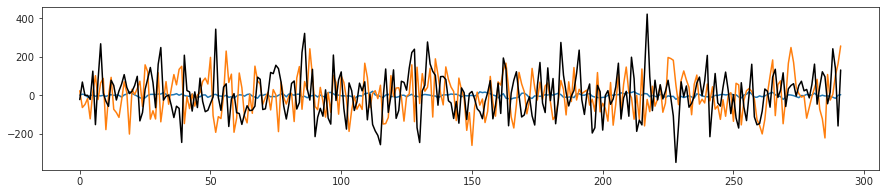

In [30]:
fig, ax = create_figure(1, 1, (15, 3))
ax.plot(bn.nanmean(data, 0))
ax.plot(data[1000])
ax.plot(data[2000], color='k');

## Save graphs

In [31]:
def _a2g(adj):
    a = adj.copy()
    a[np.isnan(a)] = 0
    return nx.from_numpy_array(a)

## Each run separately

In [32]:
%%time

n_samples = 10
percentiles = [5, 10, 15, 20, 25]

adj_all = {}
thres_all = collections.defaultdict(dict)
for key, data in tqdm(data_all.items()):
    a, _ = get_adj_mat(data, 'pearson', p_val=1)
    adj_all[key] = a

    path = '_'.join([
        f"n-{mice.cfg.nn}*{mice.cfg.ll}",
        'bp(0.008,0.28)_bold_rest_pearson',
        key,
    ])
    path = pjoin(mice.cfg.svinet_dir, path, 'real')
    thresholds = calculate_threshold(
        a, [p / 100 for p in percentiles])
    for perc, th in zip(percentiles, thresholds):
        ab = dc(a)
        ab[a <= th] = 0
        thres_all[perc][key] = th
        save_graph(_a2g(ab), perc, path, n_samples)

_ = save_obj(
    obj=adj_all,
    file_name='AD_adj',
    save_dir=tmp_dir,
    mode='npy',
)

  0%|          | 0/348 [00:00<?, ?it/s]

[PROGRESS] 'AD_adj.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

CPU times: user 3h 26min 37s, sys: 49min 9s, total: 4h 15min 46s
Wall time: 4h 21min 17s


## Session level

In [33]:
sessions = []
for k in data_all:
    sessions.append('_'.join(k.split('_')[:2]))
sessions = sorted(set(sessions))
len(sessions)

118

In [34]:
%%time

for key in sessions:
    data = np.concatenate(list(map(
        operator.itemgetter(1),
        filter(lambda t: key in t[0], data_all.items())
    )), axis=-1)
    a, _ = get_adj_mat(data, 'pearson', p_val=1)
    adj_all[key] = a
    
    path = '_'.join([
        f"n-{mice.cfg.nn}*{mice.cfg.ll}",
        'bp(0.008,0.28)_bold_rest_pearson',
        key,
    ])
    path = pjoin(mice.cfg.svinet_dir, path, 'real')
    thresholds = calculate_threshold(
        a, [p / 100 for p in percentiles])
    for perc, th in zip(percentiles, thresholds):
        ab = dc(a)
        ab[a <= th] = 0
        thres_all[perc][key] = th
        save_graph(_a2g(ab), perc, path, n_samples)

_ = save_obj(
    obj=adj_all,
    file_name='AD_adj',
    save_dir=tmp_dir,
    mode='npy',
)
len(adj_all)

[PROGRESS] 'AD_adj.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

CPU times: user 1h 10min 50s, sys: 19min 7s, total: 1h 29min 57s
Wall time: 1h 32min 36s


466

## Animal level

In [35]:
animals = []
for k in data_all:
    animals.append(k.split('_')[0])
animals = sorted(set(animals))
len(animals)

69

In [36]:
%%time

for key in animals:
    data = np.concatenate(list(map(
        operator.itemgetter(1),
        filter(lambda t: key in t[0], data_all.items())
    )), axis=-1)
    a, _ = get_adj_mat(data, 'pearson', p_val=1)
    adj_all[key] = a
    
    path = '_'.join([
        f"n-{mice.cfg.nn}*{mice.cfg.ll}",
        'bp(0.008,0.28)_bold_rest_pearson',
        key,
    ])
    path = pjoin(mice.cfg.svinet_dir, path, 'real')
    thresholds = calculate_threshold(
        a, [p / 100 for p in percentiles])
    for perc, th in zip(percentiles, thresholds):
        ab = dc(a)
        ab[a <= th] = 0
        thres_all[perc][key] = th
        save_graph(_a2g(ab), perc, path, n_samples)

_ = save_obj(
    obj=adj_all,
    file_name='AD_adj',
    save_dir=tmp_dir,
    mode='npy',
)
len(adj_all)

[PROGRESS] 'AD_adj.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

CPU times: user 42min 16s, sys: 12min 16s, total: 54min 32s
Wall time: 56min 33s


535

## Group level

In [37]:
groups = []
for k in data_all:
    g = k.split('_')[0].split('-')[1]
    g = re.findall("[a-zA-Z]+", g).pop()
    groups.append(f"sub-{g}")
groups = sorted(set(groups))
len(groups)

2

In [38]:
groups

['sub-DKI', 'sub-WT']

In [39]:
%%time

for key in groups:
    data = np.concatenate(list(map(
        operator.itemgetter(1),
        filter(lambda t: key in t[0], data_all.items())
    )), axis=-1)
    print(key, data.shape)
    a, _ = get_adj_mat(data, 'pearson', p_val=1)
    adj_all[key] = a
    
    path = '_'.join([
        f"n-{mice.cfg.nn}*{mice.cfg.ll}",
        'bp(0.008,0.28)_bold_rest_pearson',
        key,
    ])
    path = pjoin(mice.cfg.svinet_dir, path, 'real')
    thresholds = calculate_threshold(
        a, [p / 100 for p in percentiles])
    for perc, th in zip(percentiles, thresholds):
        ab = dc(a)
        ab[a <= th] = 0
        thres_all[perc][key] = th
        save_graph(_a2g(ab), perc, path, n_samples)

_ = save_obj(
    obj=adj_all,
    file_name='AD_adj',
    save_dir=tmp_dir,
    mode='npy',
)
len(adj_all)

sub-DKI
(2365, 66239)

sub-WT
(2365, 37141)

[PROGRESS] 'AD_adj.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

CPU times: user 2min 53s, sys: 1min 16s, total: 4min 9s
Wall time: 17min 12s


537

## Finalkly,  group/session

In [40]:
group_ses = []
for k in data_all:
    sub, ses, run = k.split('_')
    g = re.findall(r"[A-Z]+", sub.split('-')[1]).pop()
    group_ses.append(f"sub-{g}_{ses}")
group_ses = sorted(set(group_ses))
len(group_ses)

10

In [41]:
group_ses = {k: [] for k in group_ses}
for k in data_all:
    sub, ses, run = k.split('_')
    g = re.findall(r"[A-Z]+", sub.split('-')[1]).pop()
    group_ses[f"sub-{g}_{ses}"].append(k)
list(group_ses)

[
    'sub-DKI_ses-1',
    'sub-DKI_ses-2',
    'sub-DKI_ses-3',
    'sub-DKI_ses-5',
    'sub-DKI_ses-6',
    'sub-WT_ses-1',
    'sub-WT_ses-2',
    'sub-WT_ses-3',
    'sub-WT_ses-5',
    'sub-WT_ses-6'
]

In [42]:
%%time

for key, run_list in group_ses.items():
    data = np.concatenate(list(map(
        operator.itemgetter(1),
        filter(
            lambda t: t[0] in run_list,
            data_all.items()
        )
    )), axis=-1)
    print(key, data.shape)
    a, _ = get_adj_mat(data, 'pearson', p_val=1)
    adj_all[key] = a

    path = '_'.join([
        f"n-{mice.cfg.nn}*{mice.cfg.ll}",
        'bp(0.008,0.28)_bold_rest_pearson',
        key,
    ])
    path = pjoin(mice.cfg.svinet_dir, path, 'real')
    thresholds = calculate_threshold(
        a, [p / 100 for p in percentiles])
    for perc, th in zip(percentiles, thresholds):
        ab = dc(a)
        ab[a <= th] = 0
        thres_all[perc][key] = th
        save_graph(_a2g(ab), perc, path, n_samples)

_ = save_obj(
    obj=adj_all,
    file_name='AD_adj',
    save_dir=tmp_dir,
    mode='npy',
)
len(adj_all)

sub-DKI_ses-1
(2365, 13520)

sub-DKI_ses-2
(2365, 10775)

sub-DKI_ses-3
(2365, 9554)

sub-DKI_ses-5
(2365, 17084)

sub-DKI_ses-6
(2365, 15306)

sub-WT_ses-1
(2365, 8974)

sub-WT_ses-2
(2365, 9024)

sub-WT_ses-3
(2365, 7747)

sub-WT_ses-5
(2365, 6993)

sub-WT_ses-6
(2365, 4403)

[PROGRESS] 'AD_adj.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

CPU times: user 7min 13s, sys: 2min 23s, total: 9min 36s
Wall time: 11min 6s


547

## Plot threshold values

In [43]:
list(thres_all)

[5, 10, 15, 20, 25]

In [44]:
greys = sns.color_palette('Greys_r', n_colors=15)
greys

In [45]:
oranges = sns.color_palette('Oranges_r', n_colors=20)
oranges

In [46]:
runlevel_wt = [v for k, v in thres_all[10].items() if k in data_all and 'WT' in k]
seslevel_wt = [v for k, v in thres_all[10].items() if k in sessions and 'WT' in k]
gseslevel_wt = [v for k, v in thres_all[10].items() if k in group_ses and 'WT' in k]
runlevel_dki = [v for k, v in thres_all[10].items() if k in data_all and 'DKI' in k]
seslevel_dki = [v for k, v in thres_all[10].items() if k in sessions and 'DKI' in k]
gseslevel_dki = [v for k, v in thres_all[10].items() if k in group_ses and 'DKI' in k]

data2p_wt = {
    'run': runlevel_wt,
    'ses': seslevel_wt,
    'g_ses': gseslevel_wt,
}
data2p_dki = {
    'run': runlevel_dki,
    'ses': seslevel_dki,
    'g_ses': gseslevel_dki,
}
for k, v in data2p_wt.items():
    print(f"{k} level\t# WT: {len(v)},\t# DKI: {len(data2p_dki[k])}")

run level       # WT: 125,      # DKI: 223

ses level       # WT: 42,       # DKI: 76

g_ses level     # WT: 5,        # DKI: 5

In [47]:
def _show_thres():
    kws = {
        'stat': 'percent',
        'bins': np.linspace(0, 0.16, 33),
    }
    greys = sns.color_palette('Greys_r', n_colors=15)
    oranges = sns.color_palette('Oranges_r', n_colors=20)
    
    fig, axes = create_figure(1, len(thres_all), (13, 2.9), 'all', 'all', constrained_layout=True)
    for i, (perc, thres_dict) in enumerate(thres_all.items()):
        runlevel_wt = [v for k, v in thres_dict.items() if k in data_all and 'WT' in k]
        seslevel_wt = [v for k, v in thres_dict.items() if k in sessions and 'WT' in k]
        gseslevel_wt = [v for k, v in thres_dict.items() if k in group_ses and 'WT' in k]
        runlevel_dki = [v for k, v in thres_dict.items() if k in data_all and 'DKI' in k]
        seslevel_dki = [v for k, v in thres_dict.items() if k in sessions and 'DKI' in k]
        gseslevel_dki = [v for k, v in thres_dict.items() if k in group_ses and 'DKI' in k]

        data2p_wt = {
            'run': runlevel_wt,
            'ses': seslevel_wt,
            'g_ses': gseslevel_wt,
        }
        data2p_dki = {
            'run': runlevel_dki,
            'ses': seslevel_dki,
            'g_ses': gseslevel_dki,
        }

        ax = axes[i]
        for j, (k, v) in enumerate(data2p_wt.items()):
            sns.histplot(v, label=f'WT ({k})', color=greys[4*j + 1], ax=ax, **kws)
            sns.histplot(data2p_dki[k], label=f'DKI ({k})', color=oranges[4*j + 5], ax=ax, **kws)
        ax.set_title(f"d = {perc / 100:0.2f} %")
        if i == len(thres_all) - 1:
            ax.legend()
    plt.show()

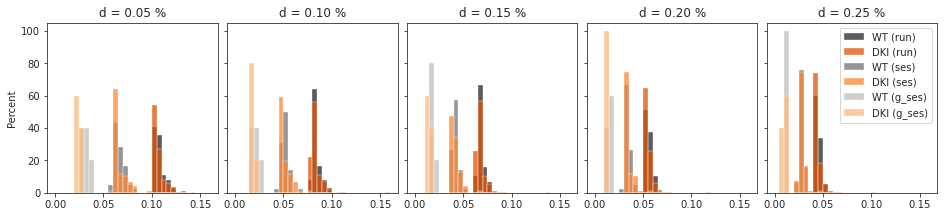

In [48]:
_show_thres()

---
---
## Edit Jan 3rd, 2023

Running below code in ```KABA``` to save graphs in svinet worspace.  Then, will run ```./loop_svinet.sh```.

In [2]:
mice = Mice(Config(128, resolution=25))
mice.set_band(band_bo=(0.008,0.28))

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

In [3]:
adj = np.load(pjoin(tmp_dir, 'AD_adj.npy'), allow_pickle=True).item()
len(adj)

547

### Save graphs from loaded adj

In [4]:
def _a2g(adj):
    a = adj.copy()
    a[np.isnan(a)] = 0
    return nx.from_numpy_array(a)


def _save_graphs(a, key, percentiles):
    path = '_'.join([
        f"n-{mice.cfg.nn}*{mice.cfg.ll}",
        'bp(0.008,0.28)_bold_rest_pearson',
        key,
    ])
    path = pjoin(mice.cfg.svinet_dir, path, 'real')
    thresholds = calculate_threshold(
        a, [p / 100 for p in percentiles])
    for perc, th in zip(percentiles, thresholds):
        ab = dc(a)
        ab[a <= th] = 0
        save_graph(_a2g(ab), perc, path, n_samples)

In [5]:
%%time

n_samples = 10
percentiles = [5, 10, 15, 20, 25]

with joblib.parallel_backend('multiprocessing'):
    joblib.Parallel(n_jobs=-1)(
        joblib.delayed(_save_graphs)
        (a, key, percentiles) for
        key, a in adj.items()
    )

CPU times: user 17.7 s, sys: 45.5 s, total: 1min 3s
Wall time: 30min 32s


## Now running this (on ```KABA```):

```bash
time ./loop_svinet.sh 128 3 10 p10-sample 500 bold rest "0.008,0.28" pearson "sub[-_0-9a-zA-Z]*"
```